# Predictive Maintenance and Cost Optimization Using CMAPSS Jet Engine Data (Business Understanding)

The primary objective is to develop predictive maintenance models that can estimate the remaining useful life (RUL) of jet engines and to explore potential cost-saving opportunities through optimized maintenance schedules.

The dataset(CMAPSS)contains multiple sets of data, each representing different operational conditions and fault modes of jet engines. The data includes:

Training Data: Multivariate time series data for engines with full operational cycles.

Test Data: Similar to training data but with truncated operational cycles.

RUL Data: The actual remaining useful life for the engines in the test dataset.

In this setup, multiple engines are run at the same time until it exceeds its degradation threshold, that engine is turned off. 4 different test type were conducted (FD001,..FD004) that has data for testing and training. The training set has the information of engines cycle till failure. The test set instead has an arbitrary numbers of cycle. With predictive maintenance, our goal is to predict the Remaining Useful Life(RUL) before each engine fails.

## SCRUM User Story with Acceptance Criteria for Two Personas

### Persona 1: Business Head
**User Story:**
As a Business Head, I want to know the Remaining Useful Life (RUL) of our machinery so that I can schedule maintenance proactively and avoid unexpected breakdowns.

**Acceptance Criteria:**
- **Given** sensor data from the machinery,
- **When** I input the data into the model,
- **Then** I should get the predicted RUL for each machine.

### Persona 2: Finance Head
**User Story:**
As a Finance Head, I want to understand the cost implications of predictive maintenance so that I can budget for maintenance activities and reduce overall operational costs.

**Acceptance Criteria:**
- **Given** the RUL predictions and maintenance cost data,
- **When** I analyze the output,
- **Then** I should get a report showing the cost savings from proactive maintenance versus reactive maintenance.

In [1]:
# Importing necessary libraries
import pandas as pd        # For data manipulation and analysis
import numpy as np         # For numerical operations
import matplotlib.pyplot as plt  # For plotting and visualizations
import seaborn as sns      # For enhanced visualizations
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.preprocessing import StandardScaler      # For standardizing features
from sklearn.linear_model import LinearRegression     # For linear regression modeling
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating the model

# Setting up seaborn for better plots
sns.set(style="whitegrid")


In [2]:
import numpy as np
import pandas as pd
import os

# Define the path where the data is stored
dataPath = 'C:/Users/adler/OneDrive/Desktop/JET ANALYSIS/CMAPSSData'

# Define column names
id_col = ['id']
cycle_col = ['cycle']
setting_cols = ['setting1', 'setting2', 'setting3']
sensor_cols = ['sensor' + str(i) for i in range(1, 22)]
rul_col = ['RUL']
all_cols = id_col + cycle_col + setting_cols + sensor_cols + rul_col

# Function to load data
def loadData(fileName):
    data = pd.read_csv(fileName, sep=" ", header=None)
    data.drop([26, 27], axis=1, inplace=True)
    data.columns = id_col + cycle_col + setting_cols + sensor_cols
    return data

# Function to add RUL to training data
def addTrainRul(data, decrease_threshold=None):
    lifeCycles = {mcId: data[data['id'] == mcId]['cycle'].max() for mcId in data['id'].unique()}
    if decrease_threshold is None: 
        decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles

# Function to load training data and add RUL
def loadTrainData(setNumber, decrease_threshold=None):
    fileName = os.path.join(dataPath, f'train_FD00{setNumber}.txt')
    data = loadData(fileName)
    lifeCycles = addTrainRul(data, decrease_threshold)
    return data, lifeCycles

# Function to load RUL data
def loadTestRul(fileName):
    data = pd.read_csv(fileName, sep=" ", header=None)
    data.drop([1], axis=1, inplace=True)
    data.columns = ['RUL']
    return data

# Function to add RUL to test data
def addTestRul(data, rulData, decrease_threshold=None):
    testRuls = {i+1: rulData.iloc[i, 0] for i in range(len(rulData))}
    lifeCycles = {mcId: data[data['id'] == mcId]['cycle'].max() + testRuls[mcId] for mcId in data['id'].unique()}
    if decrease_threshold is None: 
        decrease_threshold = 1
    ruls = [lifeCycles[row[0]] - decrease_threshold if row[1] < decrease_threshold else lifeCycles[row[0]] - row[1] for row in data.values]
    data['RUL'] = ruls
    return lifeCycles

# Function to load test data and add RUL
def loadTestData(setNumber, decrease_threshold=None):
    data = loadData(os.path.join(dataPath, f'test_FD00{setNumber}.txt'))
    rulData = loadTestRul(os.path.join(dataPath, f'RUL_FD00{setNumber}.txt'))
    lifeCycles = addTestRul(data, rulData, decrease_threshold)
    return data, lifeCycles

# Load all datasets
decrease_threshold = None
train_datasets = {}
test_datasets = {}
for setNumber in range(1, 5):
    train_datasets[setNumber], _ = loadTrainData(setNumber, decrease_threshold)
    test_datasets[setNumber], _ = loadTestData(setNumber, decrease_threshold)


Data Loading and Preprocessing: Data Loading: The function loadData() reads and processes the training and test data files, removing unnecessary columns. Adding RUL to Training Data: The addTrainRul() function calculates the Remaining Useful Life (RUL) for each entry in the training data. Adding RUL to Test Data: The addTestRul() function does the same for the test data using the provided RUL values. Combining Data: The train and test data are successfully loaded and combined with their respective RULs.

In [3]:
# Display the first few rows of each loaded dataset to check if they are loaded correctly

# Train datasets
for setNumber in range(1, 5):
    print(f"Train Dataset FD00{setNumber}:\n")
    print(train_datasets[setNumber].head())
    print("\n\n")

# Test datasets
for setNumber in range(1, 5):
    print(f"Test Dataset FD00{setNumber}:\n")
    print(test_datasets[setNumber].head())
    print("\n\n")


Train Dataset FD001:

   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1   1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2   1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3   1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4   1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  \
0  1400.60    14.62  ...   2388.02   8138.62    8.4195      0.03       392   
1  1403.14    14.62  ...   2388.07   8131.49    8.4318      0.03       392   
2  1404.20    14.62  ...   2388.03   8133.23    8.4178      0.03       390   
3  1401.87    14.62  ...   2388.08   8133.83    8.3682      0.03       392   
4  1406.22    14.62  ...   2388.04   8133.80    8.4294      0.03       393   

   sensor18  sensor19  sensor20  sensor21    RUL  
0      2388     100

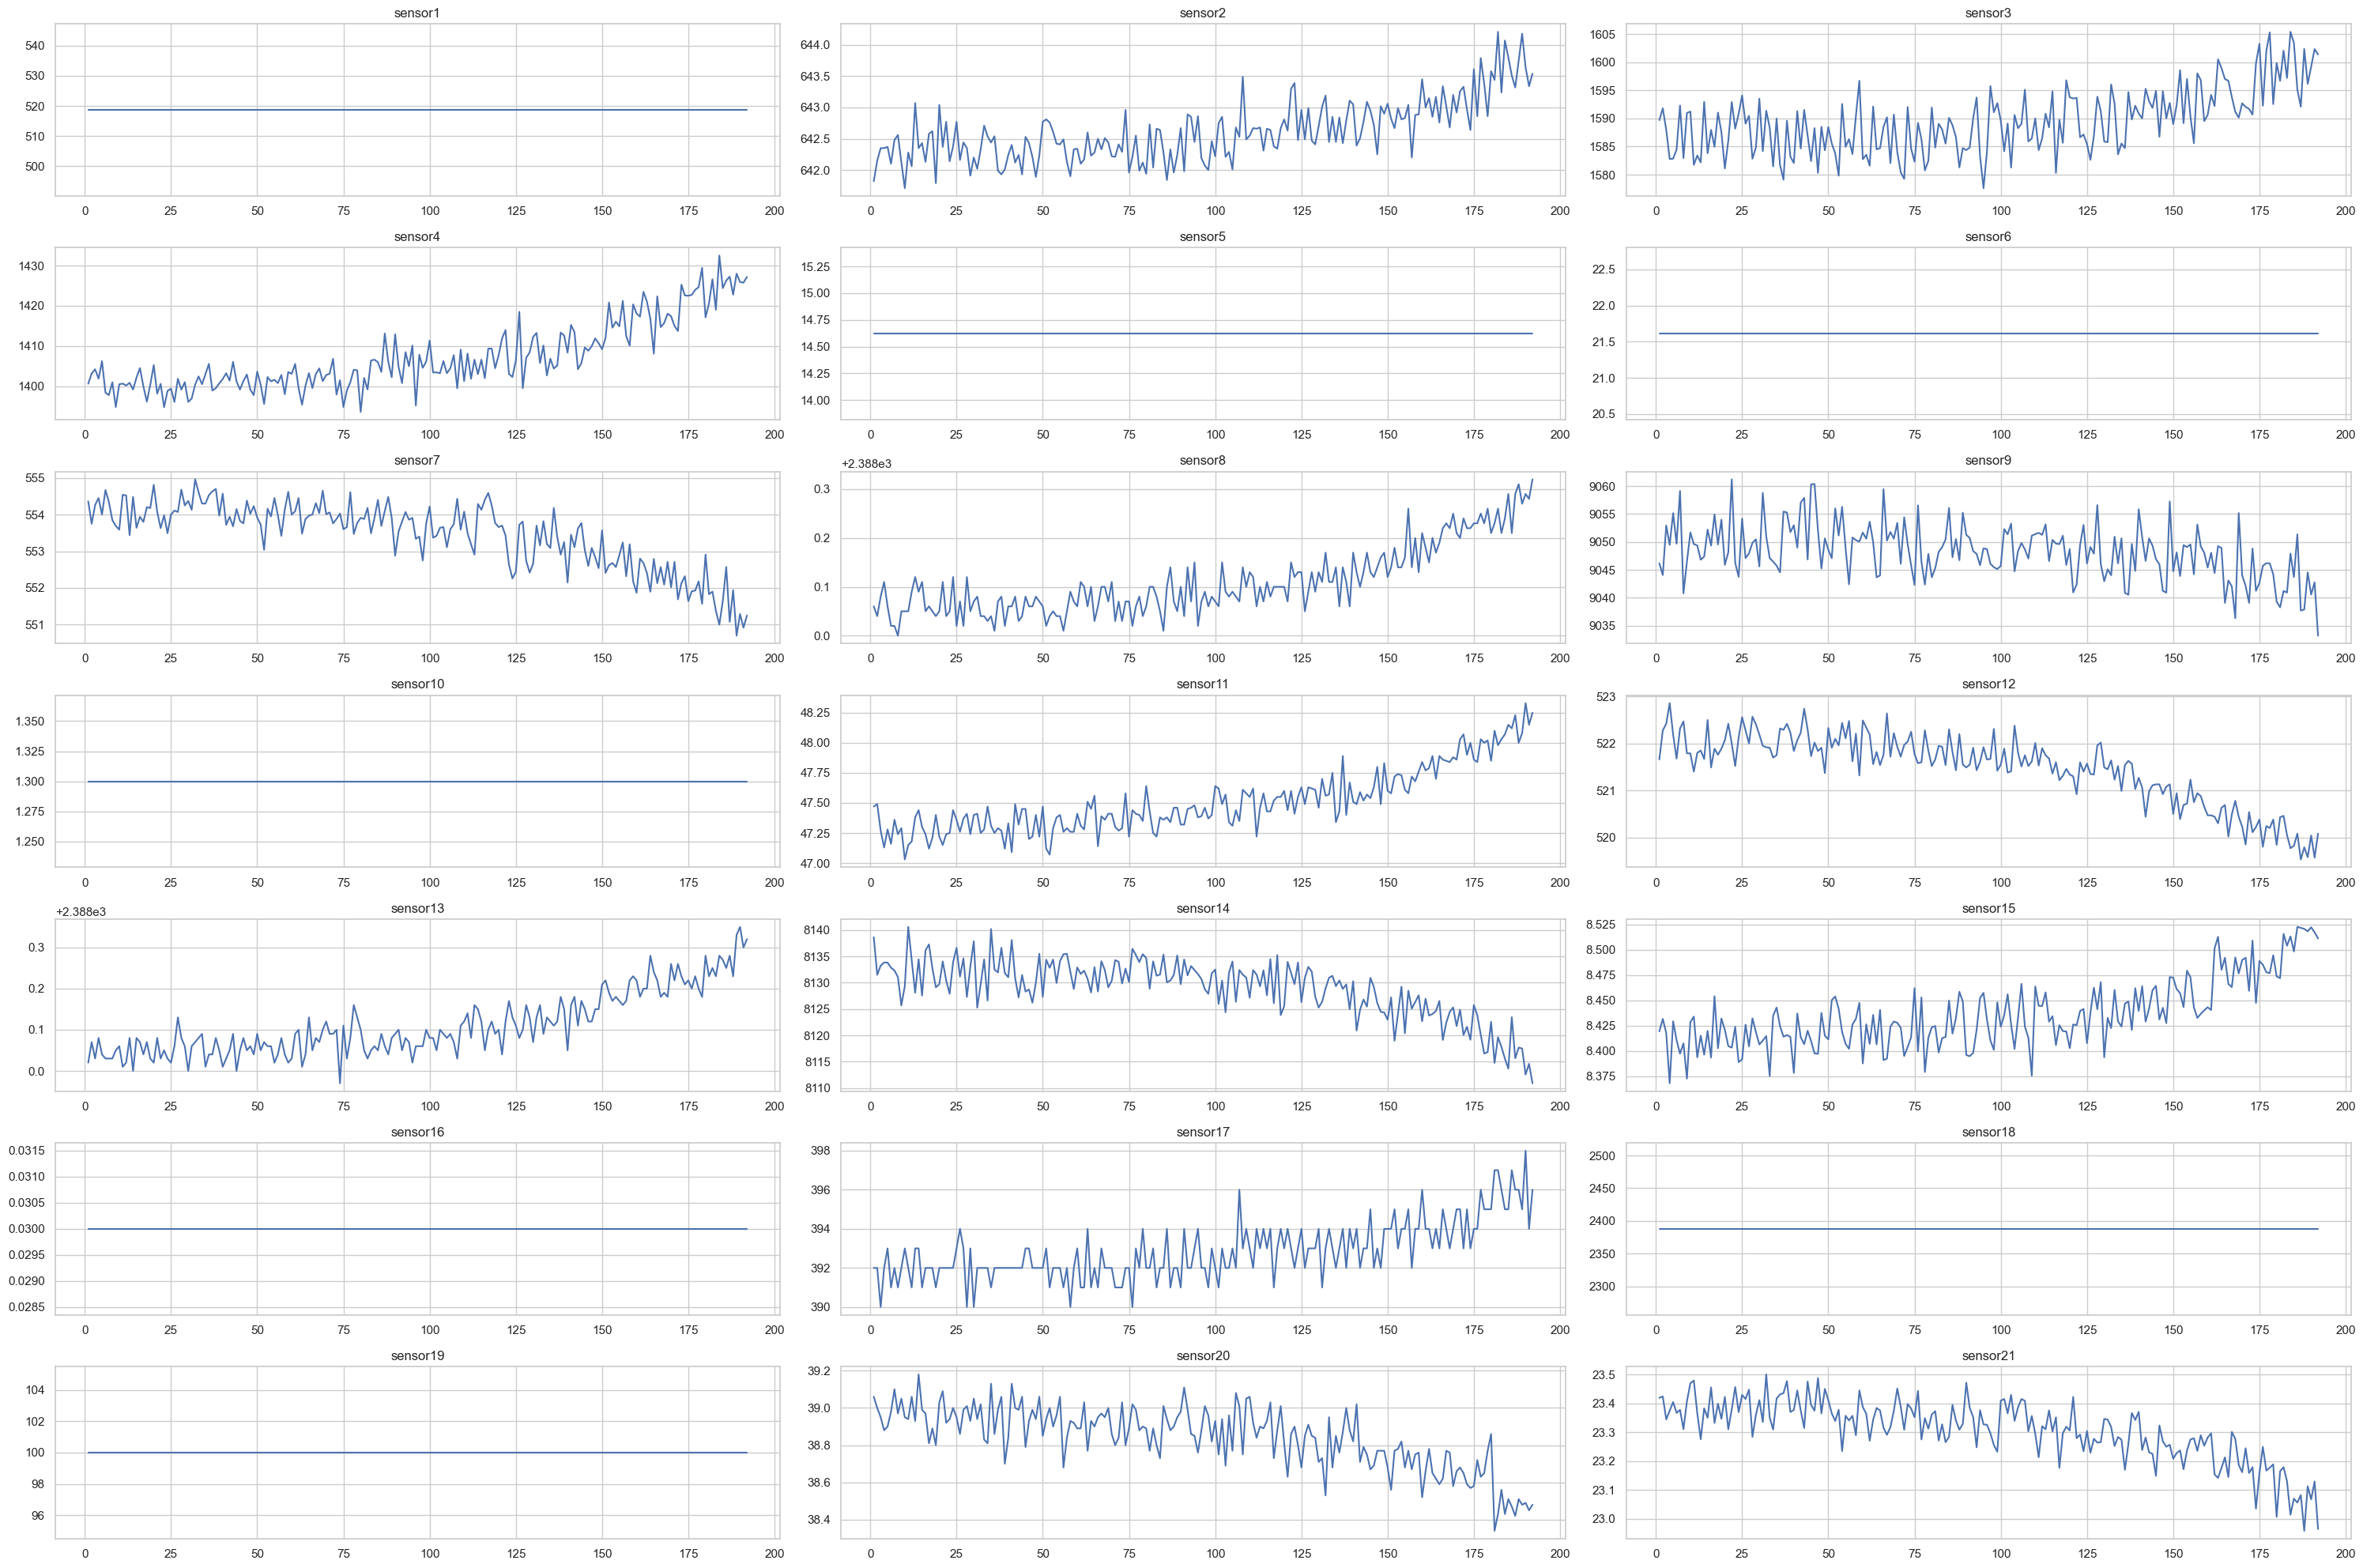

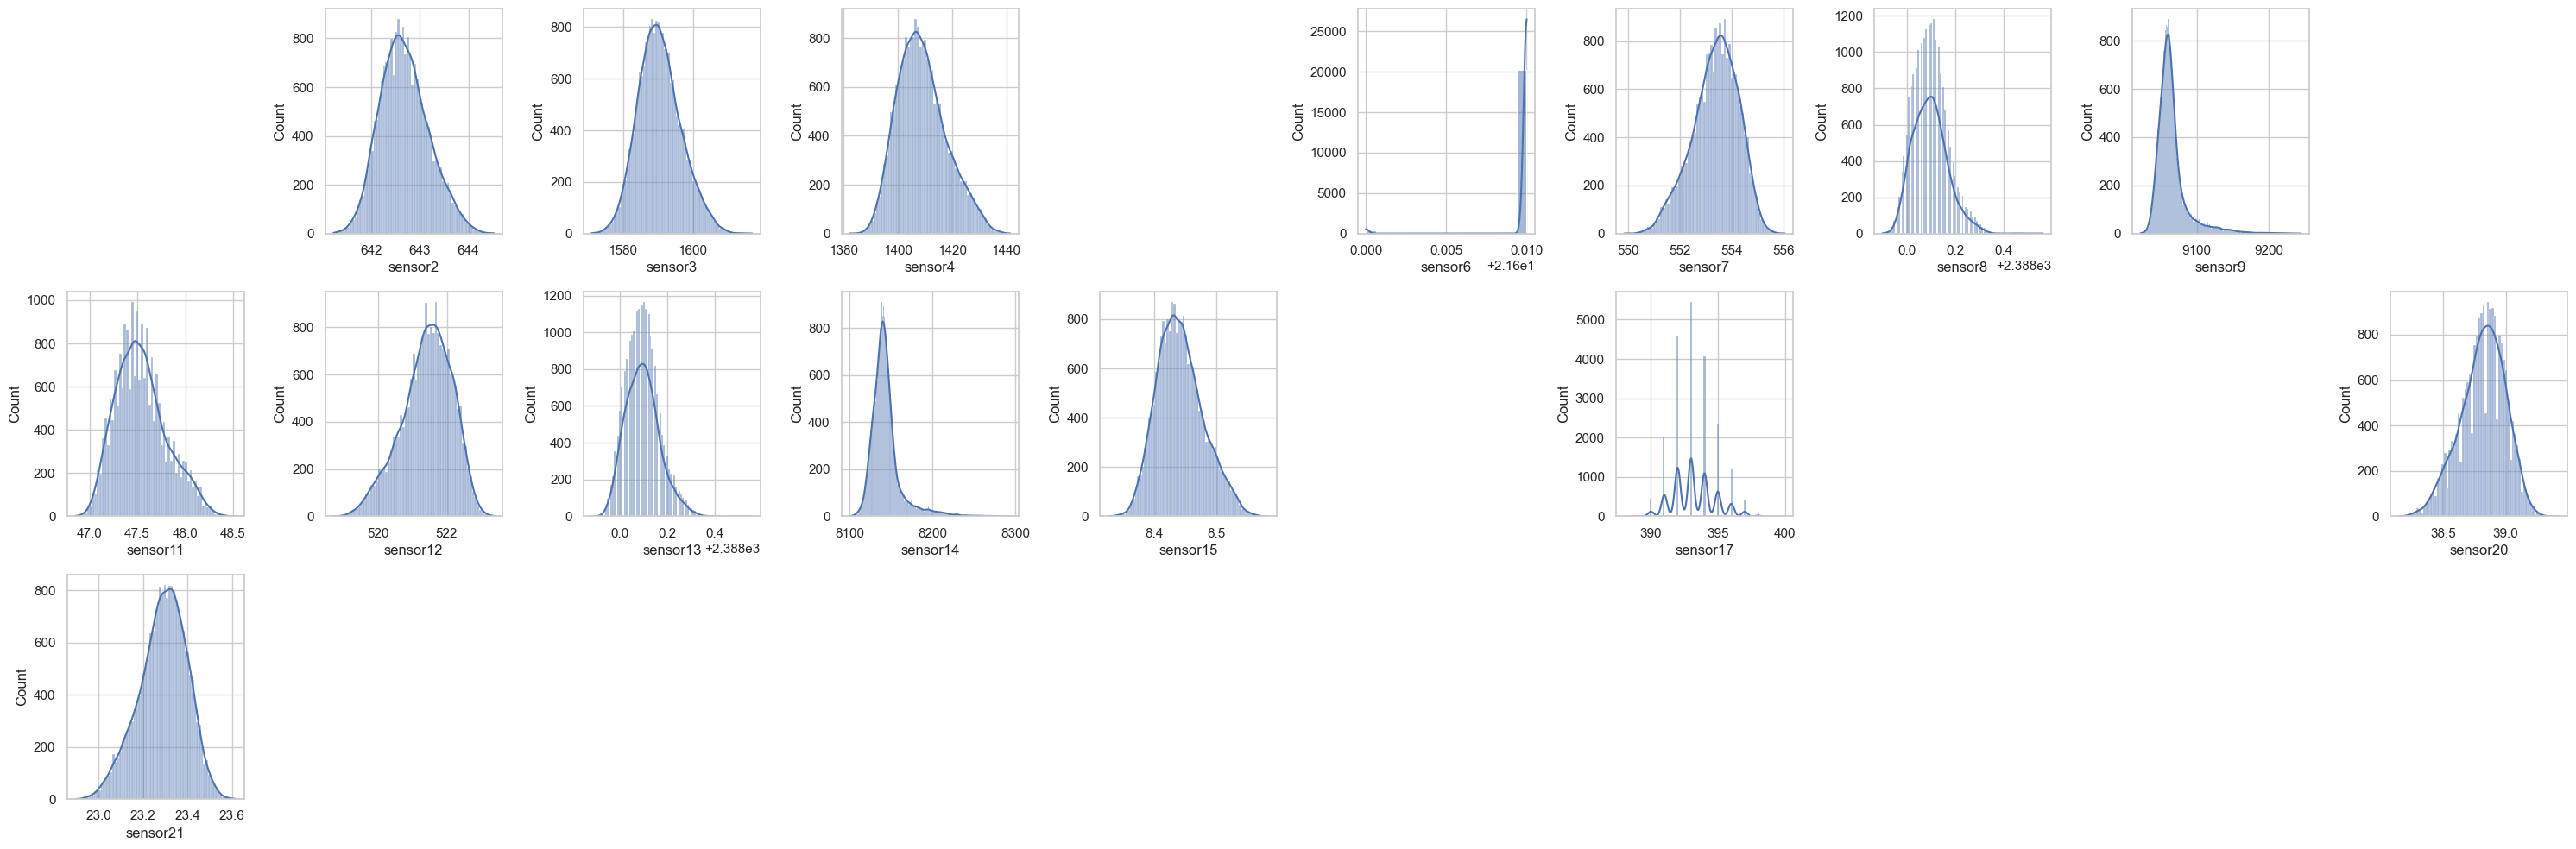

In [4]:
# Function to plot sensor data of a specific engine
def plotSensorDataOfId(data, mcId):
    plt.figure(figsize=(30, 20))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        plt.subplot(7, 3, i+1).set_title(sensor)
        ssdata = data[data['id']==mcId]
        plt.plot(ssdata['cycle'], ssdata[sensor])
    plt.tight_layout()
    plt.show()

# Function to plot data distribution
def plotDataDistribution(data):
    sensors = []
    plt.figure(figsize=(30, 10))
    for i in range(21):
        sensor = 'sensor'+str(i+1)
        if len(data[sensor].unique()) > 1:
            sensors.append(sensor)
            plt.subplot(3, 10, i + 1)
            sns.histplot(data[sensor], kde=True)
    plt.tight_layout()
    plt.show()
    return sensors

# Example usage with train dataset FD001:
# Plot sensor data for engine ID 1 in train_FD001
plotSensorDataOfId(train_datasets[1], 1)

# Plot data distribution for train_FD001
sensors = plotDataDistribution(train_datasets[1])

plotSensorDataOfId and plotDataDistribution is used to visualize the sensor data and distribution of sensor data.


### CORRELATION ANALYSIS

The correlation analysis will help in identifying and removing redundant features based on their correlations, leading to a more streamlined and potentially more effective dataset for modeling.

In [5]:
import pandas as pd
import seaborn as sns

# Function to create and display a colored correlation table
def displayColoredCorrelationTable(data):
    # Remove constant columns
    data = data.loc[:, (data != data.iloc[0]).any()]
    # Calculate correlation matrix
    corr = data.corr()
    
    # Use a diverging color palette
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Apply the color map
    styled_corr = corr.style.background_gradient(cmap=cmap).format(precision=2)
    
    # Display the styled DataFrame
    display(styled_corr)

# Create and display the colored correlation table for the training data
sensor_data = train_datasets[1][sensor_cols]
displayColoredCorrelationTable(sensor_data)


,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
sensor2,1.00,0.60,0.71,0.13,-0.70,0.66,0.27,0.74,-0.72,0.66,0.18,0.68,0.63,-0.66,-0.67
sensor3,0.60,1.00,0.68,0.12,-0.66,0.60,0.32,0.70,-0.68,0.60,0.24,0.64,0.60,-0.63,-0.63
sensor4,0.71,0.68,1.00,0.15,-0.79,0.75,0.30,0.83,-0.82,0.75,0.19,0.76,0.70,-0.75,-0.75
sensor6,0.13,0.12,0.15,1.00,-0.16,0.15,0.02,0.16,-0.16,0.16,-0.00,0.15,0.13,-0.14,-0.14
sensor7,-0.70,-0.66,-0.79,-0.16,1.00,-0.77,-0.22,-0.82,0.81,-0.76,-0.11,-0.75,-0.69,0.74,0.74
sensor8,0.66,0.60,0.75,0.15,-0.77,1.00,-0.03,0.78,-0.79,0.83,-0.14,0.70,0.63,-0.69,-0.69
sensor9,0.27,0.32,0.30,0.02,-0.22,-0.03,1.00,0.27,-0.21,-0.03,0.96,0.29,0.34,-0.29,-0.29
sensor11,0.74,0.70,0.83,0.16,-0.82,0.78,0.27,1.00,-0.85,0.78,0.16,0.78,0.72,-0.77,-0.77
sensor12,-0.72,-0.68,-0.82,-0.16,0.81,-0.79,-0.21,-0.85,1.00,-0.79,-0.10,-0.77,-0.70,0.75,0.76
sensor13,0.66,0.60,0.75,0.16,-0.76,0.83,-0.03,0.78,-0.79,1.00,-0.15,0.70,0.63,-0.69,-0.69


High positive correlations suggest that these sensors tend to increase together(sensor2 and sensor4: 0.71
sensor2 and sensor11: 0.74
sensor4 and sensor11: 0.83
sensor11 and sensor13: 0.78)
sensor9 and sensor 14: 0.96)

### NORMALIZING

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define column names
id_col = ['id']
cycle_col = ['cycle']
setting_cols = ['setting1', 'setting2', 'setting3']
sensor_cols = ['sensor' + str(i) for i in range(1, 22)]

# Function to normalize data
def normalizeData(data, scaler=None):
    # Remove constant columns
    data = data.loc[:, (data != data.iloc[0]).any()]
    features = setting_cols + sensor_cols
    features = [feature for feature in features if feature in data.columns]  # Ensure only existing columns are used
    if scaler is None:
        scaler = StandardScaler().fit(data[features].values)
    normalized_data = scaler.transform(data[features].values)
    normalized_df = pd.DataFrame(normalized_data, columns=features)
    data.loc[:, features] = normalized_df
    return data, scaler

In [7]:
# Normalize train and test datasets
normalized_train, scaler = normalizeData(train_datasets[1].copy())
normalized_test, _ = normalizeData(test_datasets[1].copy(), scaler)

In [8]:
# Plot distribution of normalized data
def plotNormalizedDistribution(data):
    plt.figure(figsize=(20, 15))
    for i, feature in enumerate(sensor_cols, 1):
        if feature in data.columns:
            plt.subplot(7, 3, i)
            sns.histplot(data[feature], kde=True)
            plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()

In [9]:
# Visualize sensor data for a specific engine
def plotSensorDataForEngine(data, engine_id):
    plt.figure(figsize=(20, 15))
    engine_data = data[data['id'] == engine_id]
    for i, feature in enumerate(sensor_cols, 1):
        if feature in engine_data.columns:
            plt.subplot(7, 3, i)
            plt.plot(engine_data['cycle'], engine_data[feature])
            plt.title(f'{feature} over time for engine {engine_id}')
    plt.tight_layout()
    plt.show()



In [10]:
# Visualize sensor data for a specific engine
def plotSensorDataForEngine(data, engine_id):
    plt.figure(figsize=(20, 15))
    engine_data = data[data['id'] == engine_id]
    for i, feature in enumerate(sensor_cols, 1):
        if feature in engine_data.columns:
            plt.subplot(7, 3, i)
            plt.plot(engine_data['cycle'], engine_data[feature])
            plt.title(f'{feature} over time for engine {engine_id}')
    plt.tight_layout()
    plt.show()



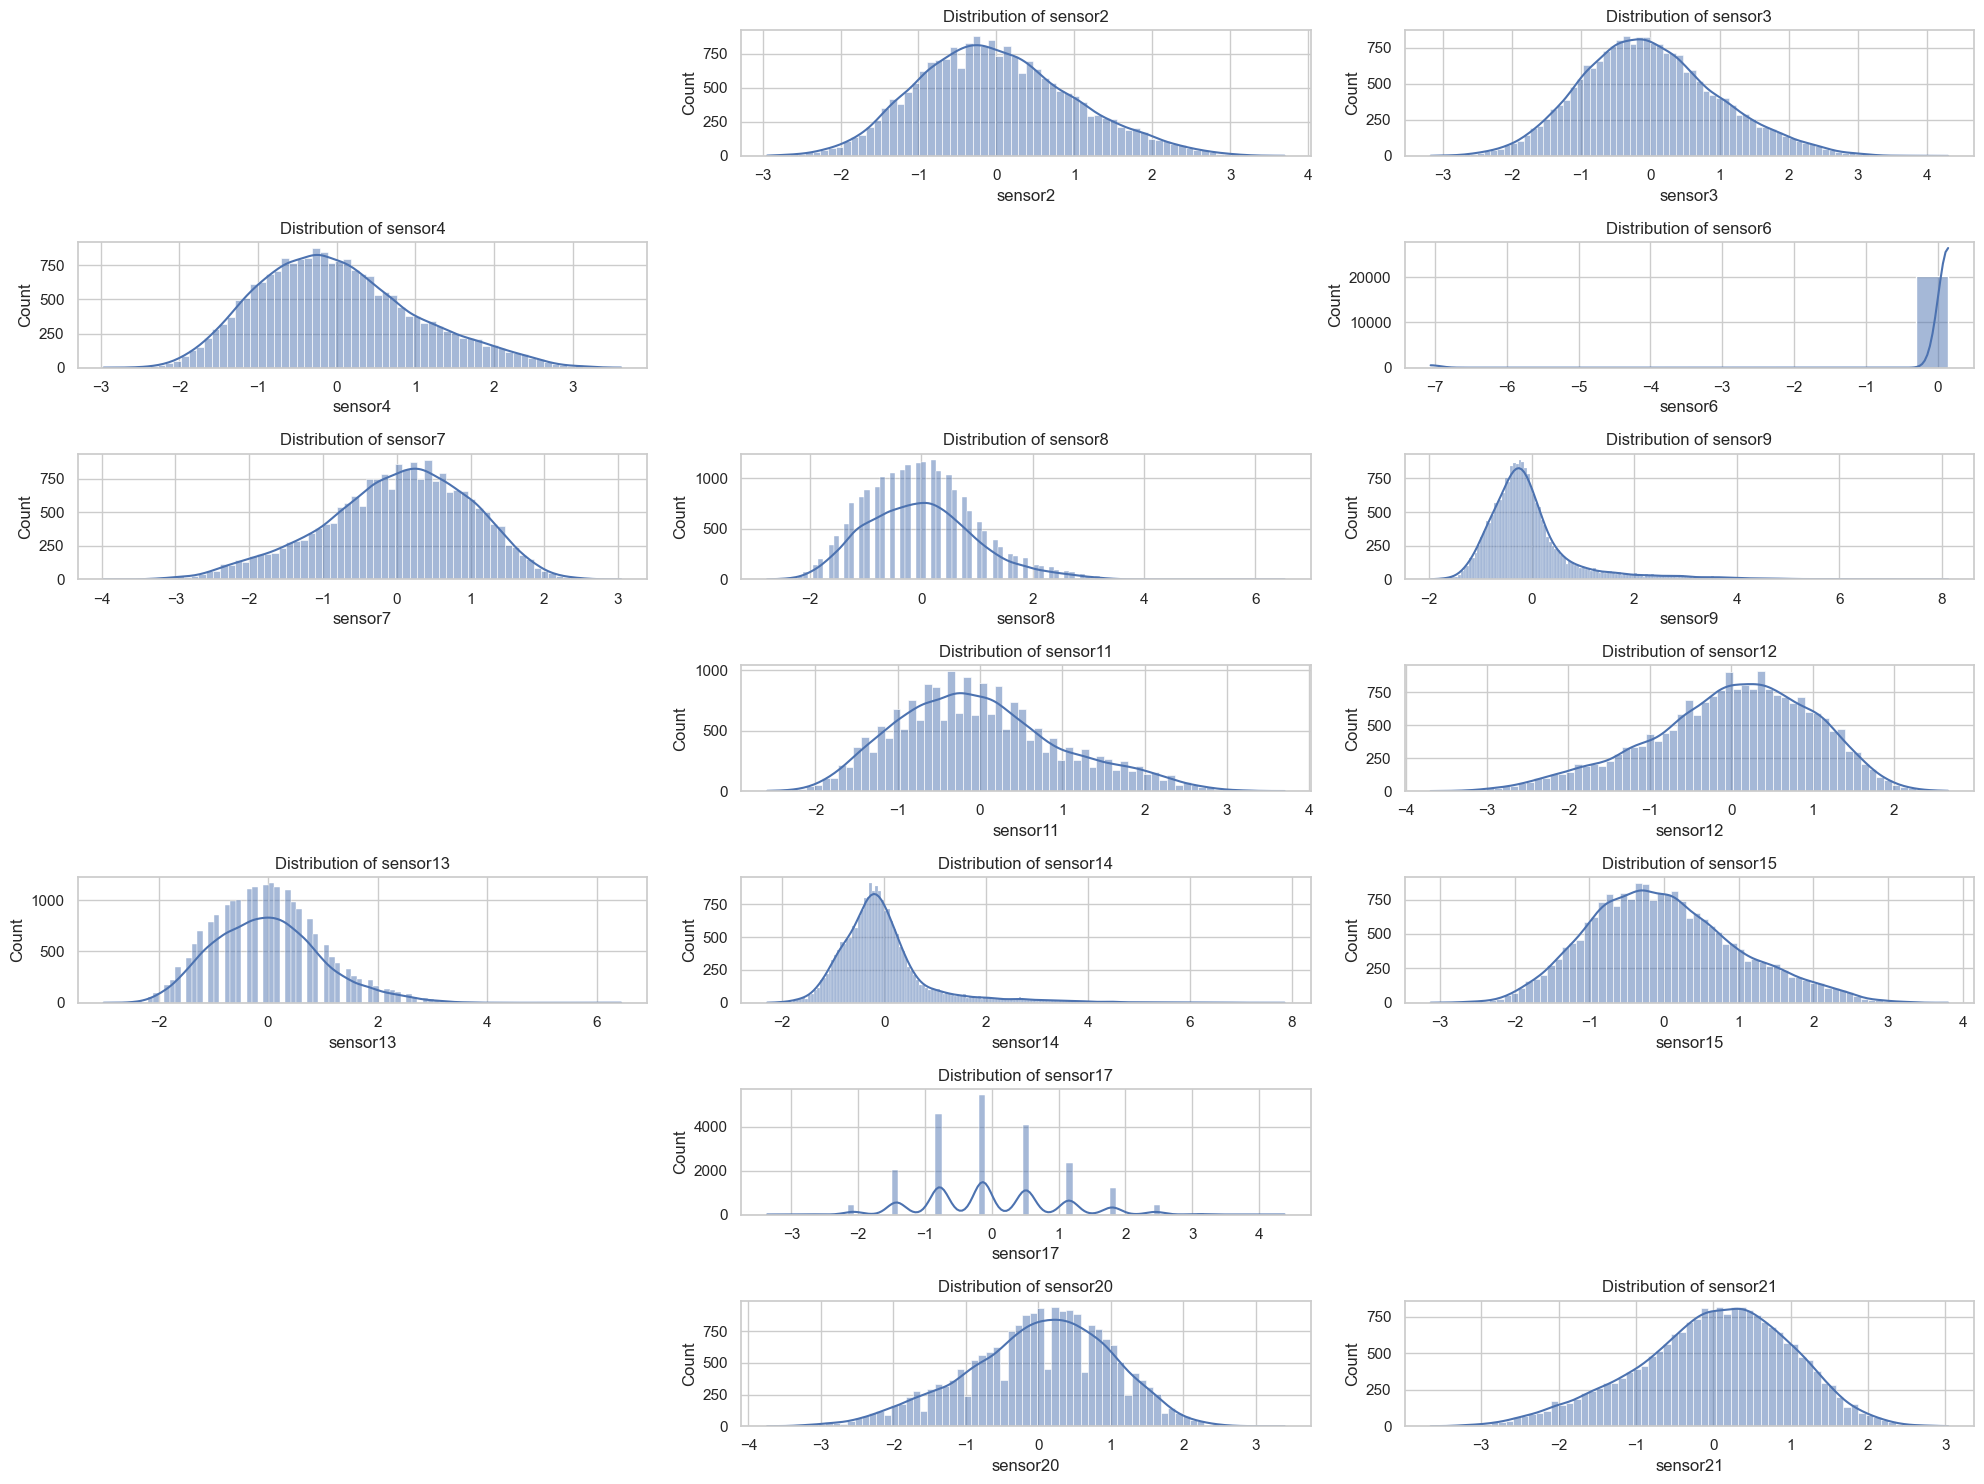

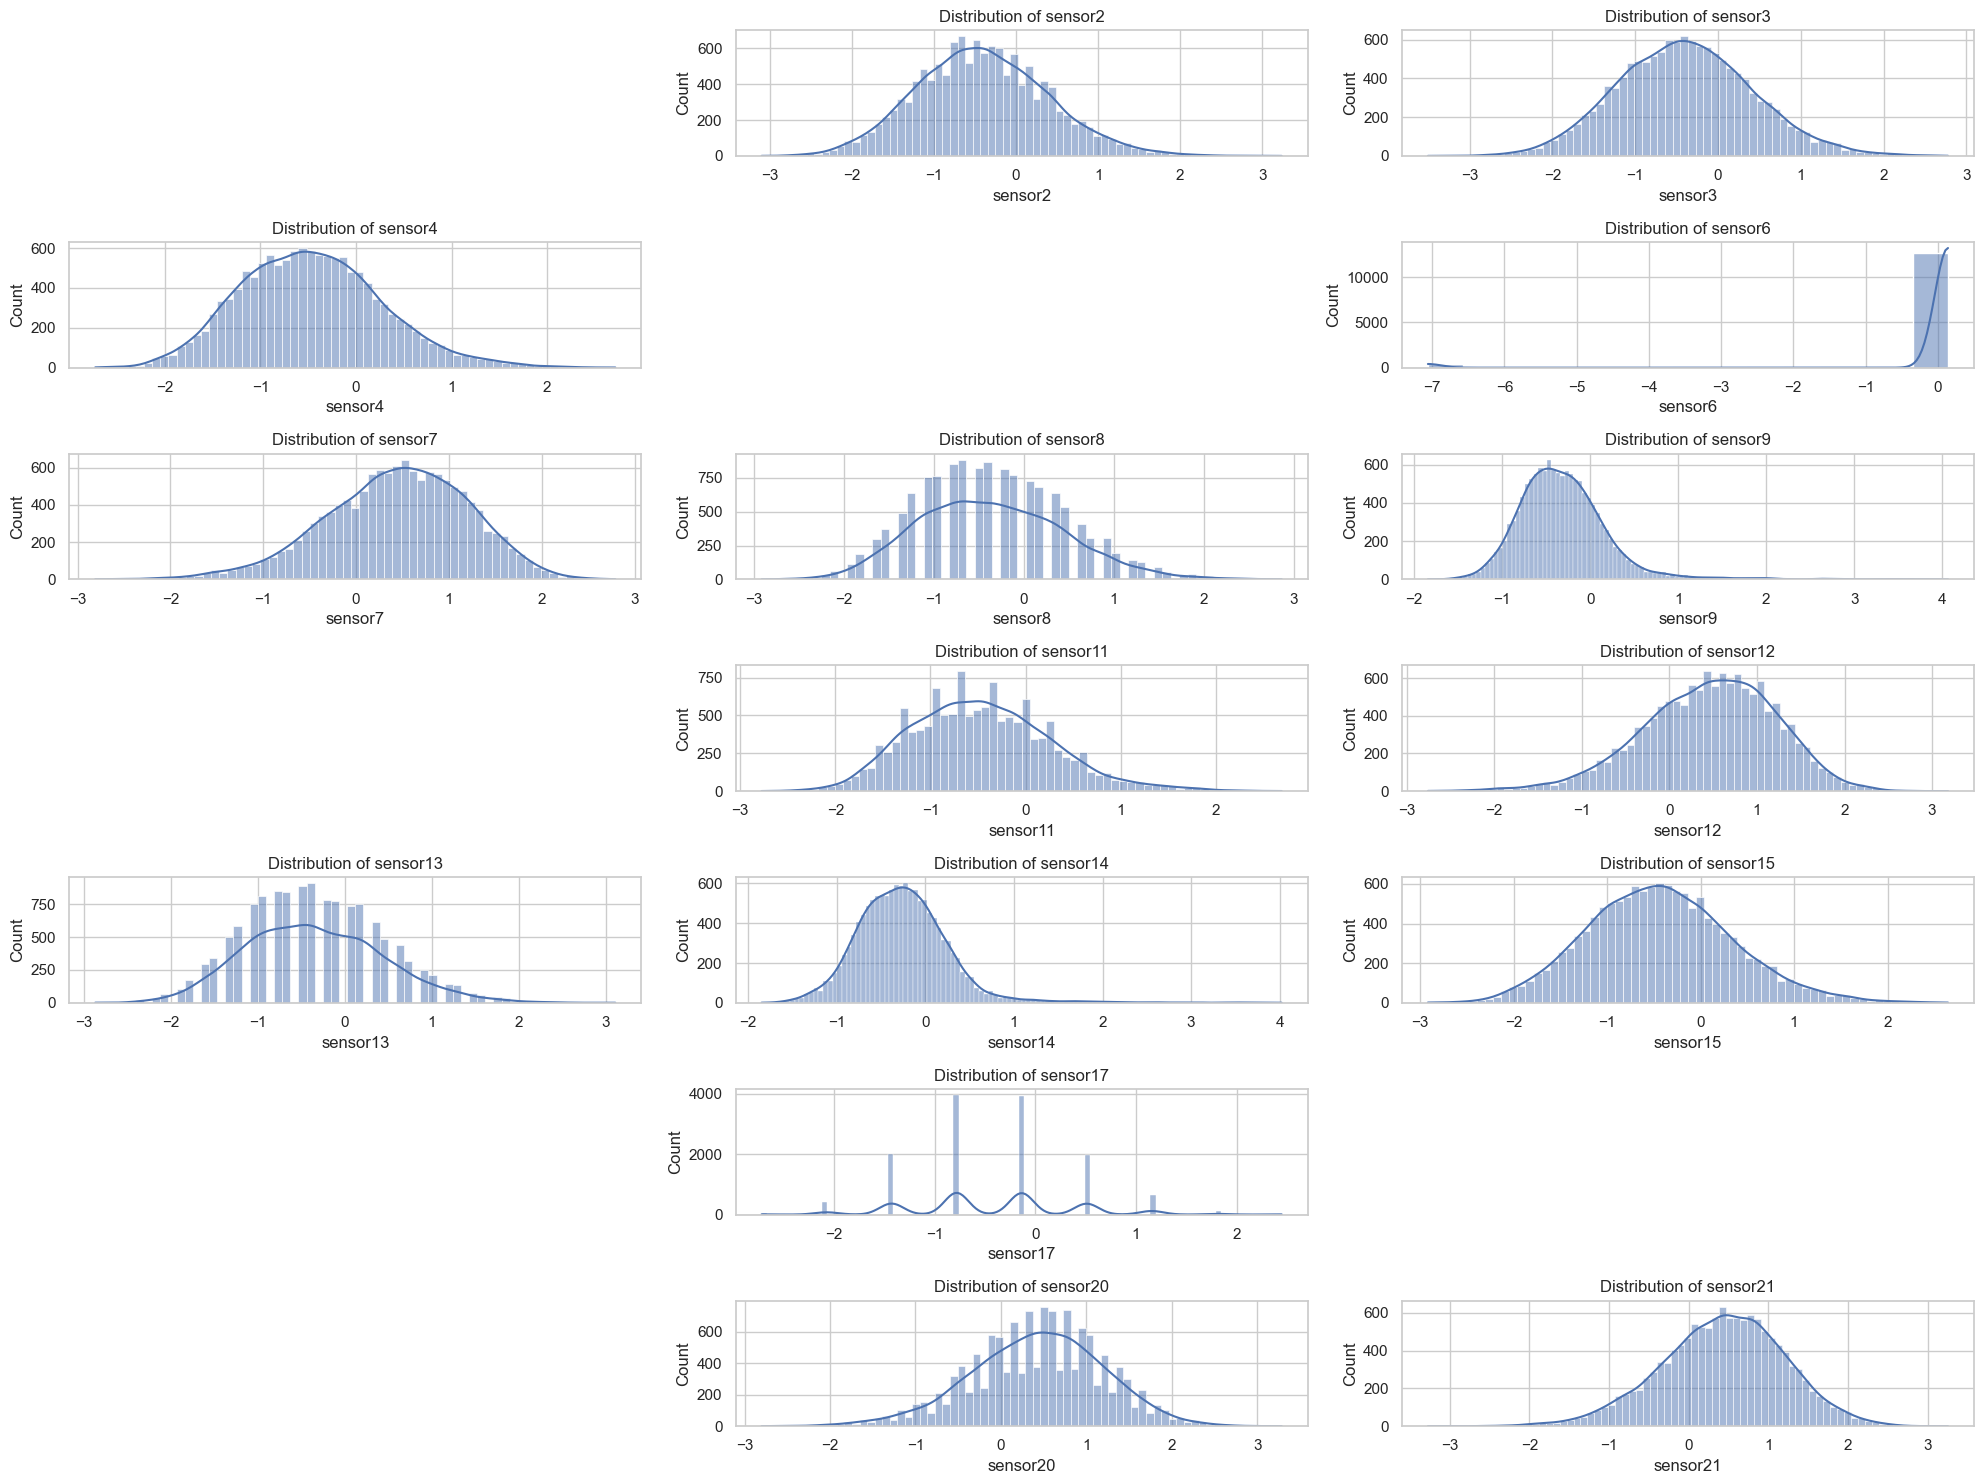

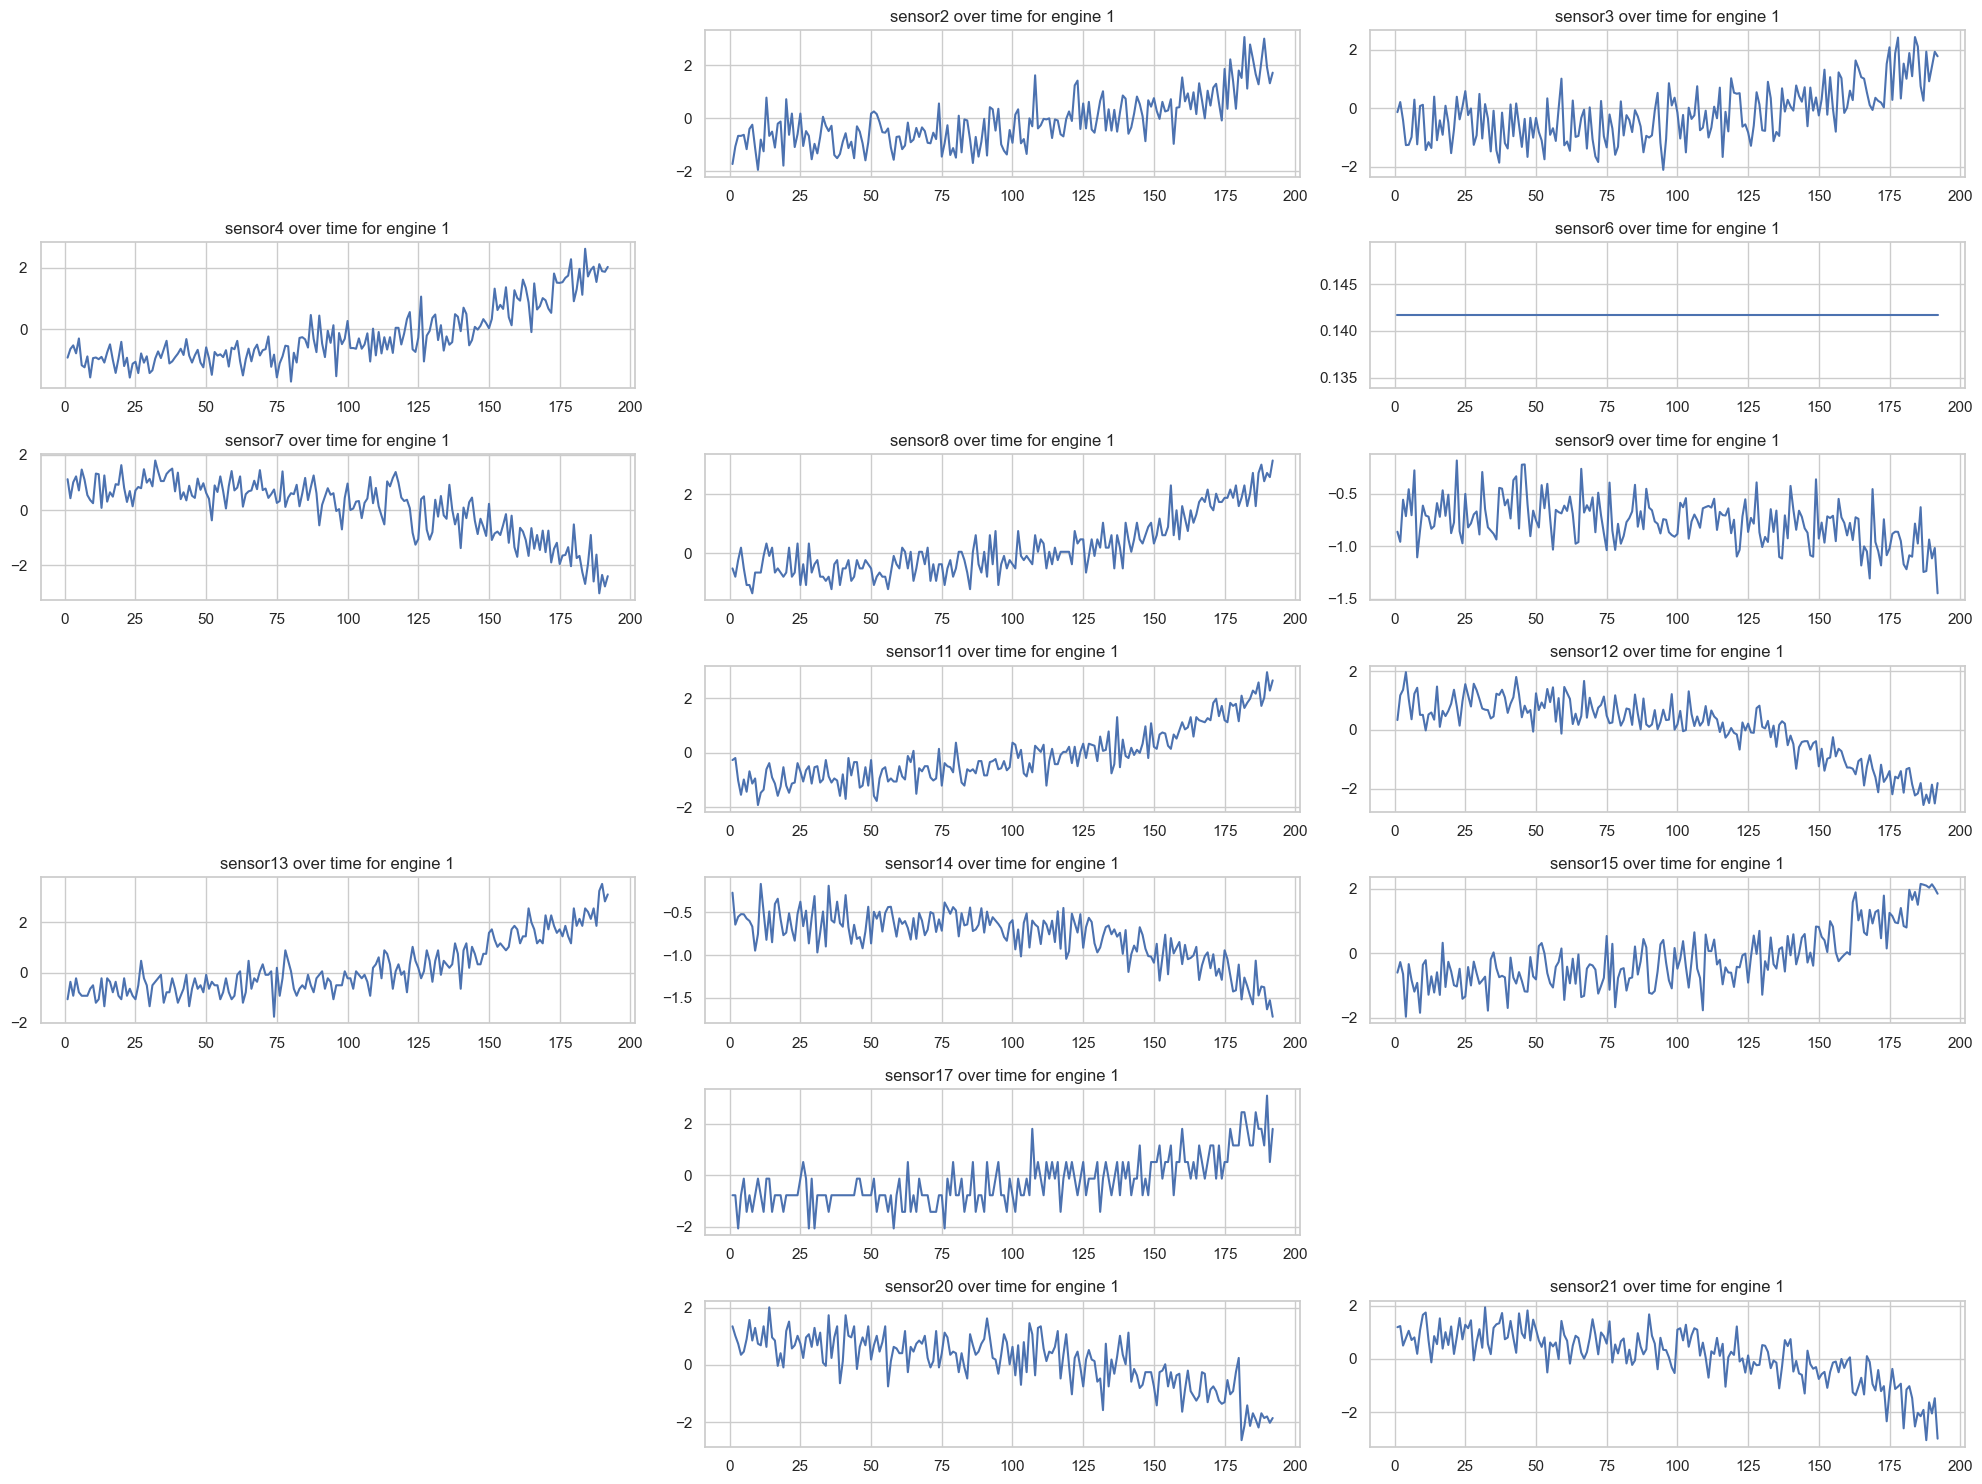

In [11]:
# Plot the distributions
plotNormalizedDistribution(normalized_train)
plotNormalizedDistribution(normalized_test)

# Plot the sensor data for engine 1
plotSensorDataForEngine(normalized_train, 1)

Applied the normalization function to both the training and test datasets.
It ensures that all features have a mean of 0 and a standard deviation of 1, which will help to improve the performance and convergence speed of many machine learning algorithms.The same scaler is used for both to ensure consistency in scaling and plotted the distribution of the normalized training and test data to make sure the normalization process didn't distort the data.
Visualized the sensor data for a specific engine (ID 1) to ensure that the normalized data retained its original shape and trends.


PIECE-WISE DATA AUGMENTATION

In [12]:
import numpy as np
import random

def getPieceWiseData(data, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    uniqueIds = data['id'].unique()
    if movingAverage is None:
        result = [data[data['id'] == mId].values for mId in uniqueIds]
    else:
        result = [data[data['id'] == mId].rolling(movingAverage).mean().dropna().values for mId in uniqueIds]
    maxlen = np.max([len(x) for x in result])
    

    # Augment the data now
    if augmentStartCycle is not None and augmentEndCycle is not None:
        result1 = []
        for mc in result:
            maxCycle = len(mc)
            for i in range(50):
                idx = random.randint(max([maxCycle - 145, 10]), max([maxCycle - 10, 10]))
                if len(mc[:idx, :]) > 0:
                    result1.append(mc[:idx, :])
        result = result1

    # Calculate the RULs (-1 is the last column for RUL)
    ruls = [min(mc[:, -1]) for mc in result]
    return result, ruls, maxlen


The function generates piece-wise data segments from the original dataset.
It can optionally apply a moving average for noise reduction.
Data augmentation is done by generating multiple segments from each machine's data.
RUL values from the augmented data segments are extracted to ensure that we have the necessary information for each segment to train our model.

In [13]:
from keras.preprocessing.sequence import pad_sequences

# Function to get padded sequences
def getPaddedSequence(data, pad_type='pre', maxlen=None, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    piece_wise, ruls, ml = getPieceWiseData(data, augmentStartCycle, augmentEndCycle, movingAverage)
    if maxlen is None:
        maxlen = ml
    padded_sequence = pad_sequences(piece_wise, padding=pad_type, maxlen=maxlen, dtype='float32')
    return padded_sequence, ruls, maxlen

# Example usage
augmentStartCycle = 130
augmentEndCycle = 362
maxlen = 200
movingAverage = None 


padded_train, train_ruls, maxlen = getPaddedSequence(normalized_train, maxlen=maxlen, augmentStartCycle=augmentStartCycle, augmentEndCycle=augmentEndCycle, movingAverage=movingAverage)
padded_test, test_ruls, maxlen = getPaddedSequence(normalized_test, maxlen=maxlen, movingAverage=movingAverage)



Padding will ensure that all sequences are of the same length. This preprocessing can lead to more uniform and consistent data, which may appear smoother when visualized.
This preprocessing is done to create uniformly sized sequences, crucial for training models like LSTMs.

In [14]:
print(padded_train.shape)


(5000, 200, 20)


In [15]:
# Adjust sensor indices based on the dimensions of padded_train
sensor_indices = list(range(20))  # All sensors within the range 0 to 19

def plotSensorDataForEngine(padded_data, engine_index, sensor_indices, maxlen):
    plt.figure(figsize=(20, 15))
    for i, sensor_idx in enumerate(sensor_indices, 1):
        plt.subplot(7, 3, i)
        values = padded_data[engine_index][:, sensor_idx]
        plt.plot(range(maxlen), values)
        plt.title(f'Sensor {sensor_idx+1} over time for engine {engine_index}')
    plt.tight_layout()
    plt.show()

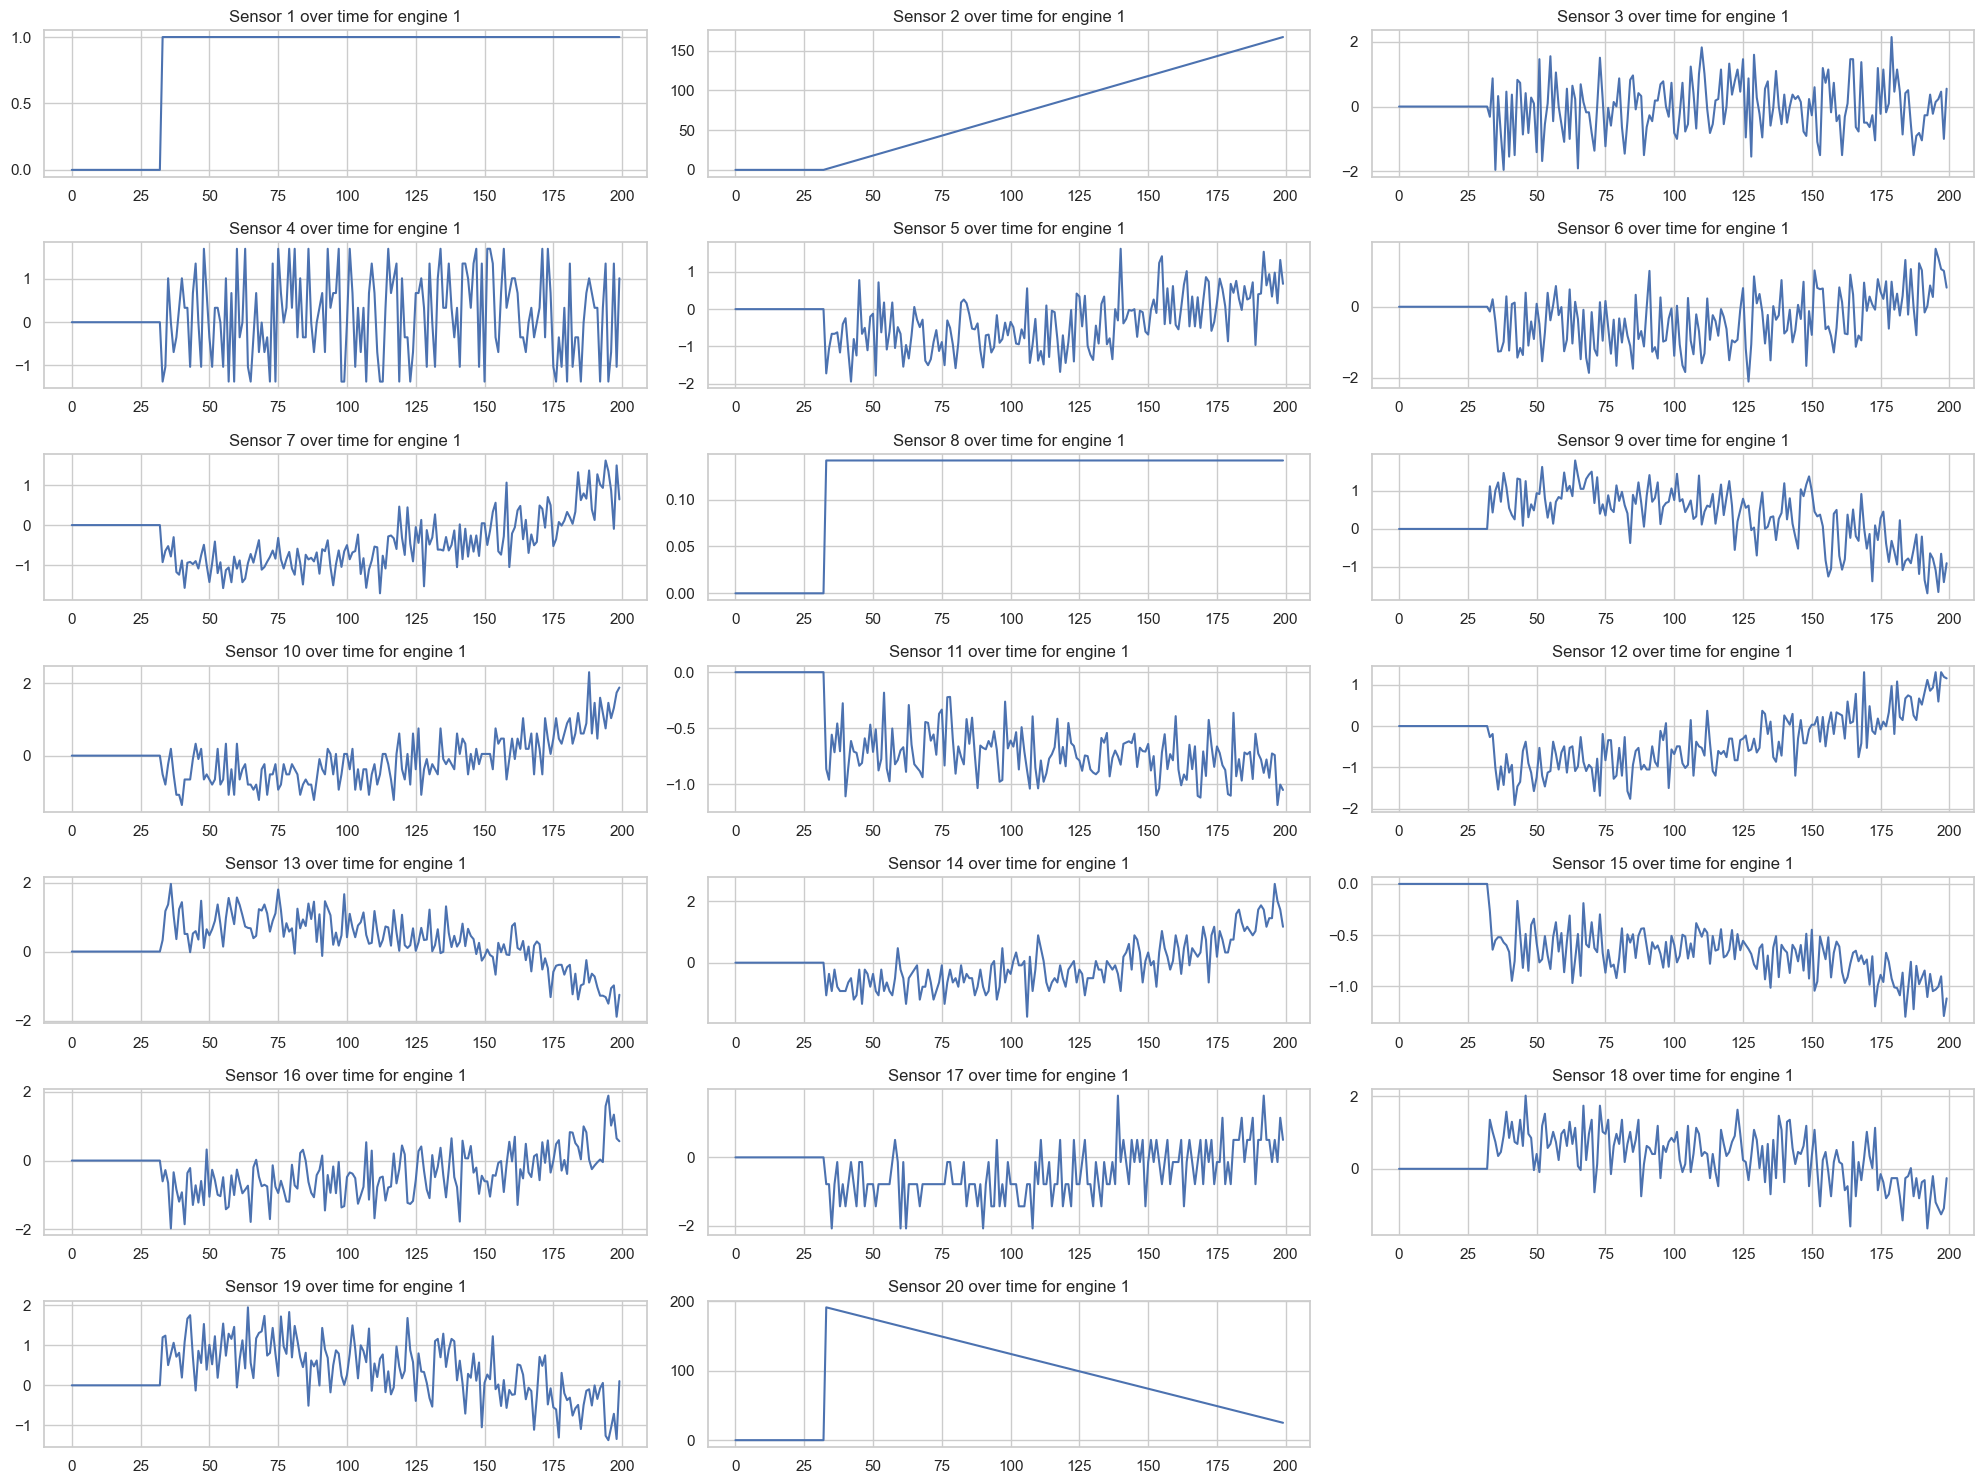

In [16]:
# Plot sensor data for a few selected engines
selected_engines = [1]  # Change these indices as needed

for engine_index in selected_engines:
    plotSensorDataForEngine(padded_train, engine_index, sensor_indices, maxlen)

plotDataForIndex(padded_train, 1) is executed to visualize the augmented and padded data for engine index 1.This helps in identifying any sensors that show distinct patterns or anomalies, which can be crucial for the prediction task

Augmentation and padding can sometimes result in smoother data sequences. Augmentation can introduce variations that help the model generalize better, while padding ensures that all sequences are of the same length. This preprocessing can lead to more uniform and consistent data, which may appear smoother when visualized. However, it's important to verify this visually to ensure that the preprocessing steps have the desired effect and do not inadvertently introduce artifacts or distortions.

### FEATURE SELECTION 

#### Splitting Data for Feature Importance (Random forest Clssifier)


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier


# Separate features and target variable
X_imp = normalized_train.drop(columns=["RUL", "id", "cycle"])
y_imp = normalized_train["RUL"]

# Print the shapes of the features and target variable to verify
print("Shape of X_imp (features):", X_imp.shape)
print("Shape of y_imp (target):", y_imp.shape)


Shape of X_imp (features): (20631, 17)
Shape of y_imp (target): (20631,)


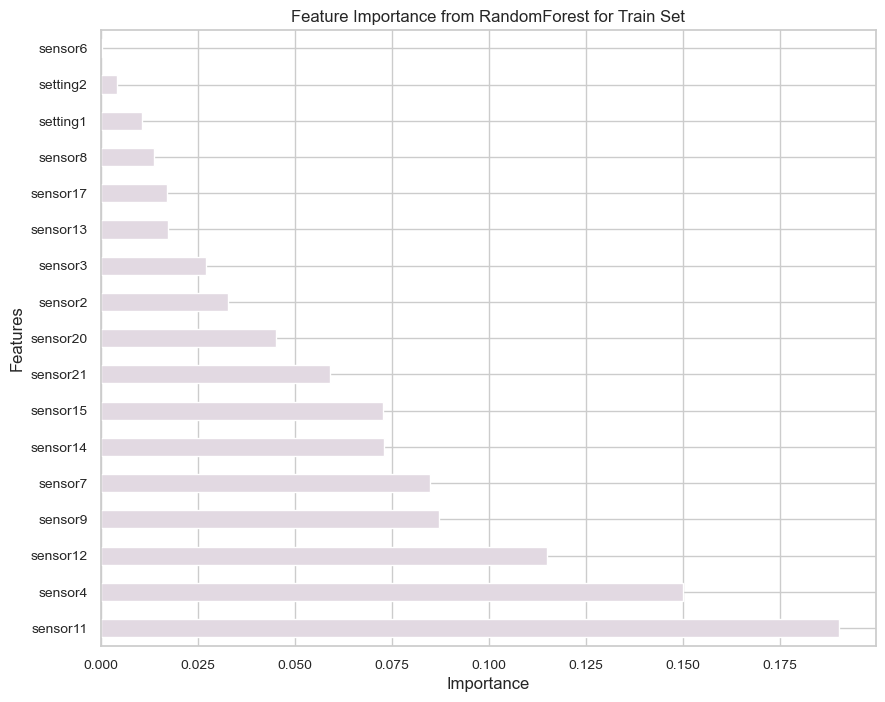

In [18]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Train the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42)
rf_clf.fit(X_imp, y_imp)

# Get feature importances from the trained model
feature_importances = rf_clf.feature_importances_

# Plot the feature importances
features = X_imp.columns
importances = pd.Series(feature_importances, index=features)
importances.nlargest(len(features)).plot(kind='barh', figsize=(10, 8), title='Feature Importance from RandomForest for Train Set', colormap='twilight', fontsize=10)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


#### Permutation Importance

ermutation importance is computed to assess the impact of each feature on the model's performance.
This method permutes each feature and measures the decrease in model performance, indicating how much the model relies on each feature.
The results are visualized using a box plot to show the distribution of importances.
The mean and standard deviation of importances for each feature are printed.

In [19]:
from sklearn.inspection import permutation_importance


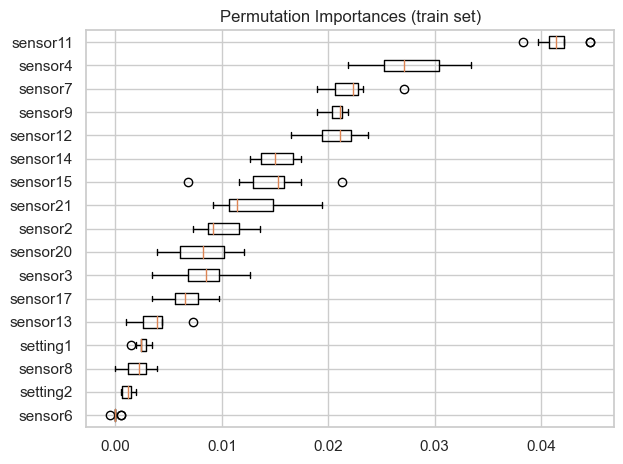

sensor11 0.042 +/- 0.002
sensor4  0.028 +/- 0.004
sensor7  0.022 +/- 0.002
sensor9  0.021 +/- 0.001
sensor12 0.021 +/- 0.002
sensor14 0.015 +/- 0.002
sensor15 0.015 +/- 0.004
sensor21 0.013 +/- 0.003
sensor2  0.010 +/- 0.002
sensor20 0.008 +/- 0.003
sensor3  0.008 +/- 0.003
sensor17 0.007 +/- 0.002
sensor13 0.004 +/- 0.002
setting1 0.003 +/- 0.001
sensor8  0.002 +/- 0.001
setting2 0.001 +/- 0.000
sensor6  0.000 +/- 0.000


In [20]:
# Use a smaller subset of data
X_imp_subset = X_imp.sample(frac=0.1, random_state=42)
y_imp_subset = y_imp.sample(frac=0.1, random_state=42)

# Perform permutation importance on the subset
result = permutation_importance(rf_clf, X_imp_subset, y_imp_subset, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

# Plot the permutation importances
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_imp.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

# Print the importances
for i in result.importances_mean.argsort()[::-1]:
     print(f"{X_imp.columns[i]:<8} "
           f"{result.importances_mean[i]:.3f}"
           f" +/- {result.importances_std[i]:.3f}")


High Importance: Features like sensor11, sensor4, sensor7, and sensor9 have high importance scores, indicating they are crucial for the model's performance.

hgdhfjg

In [21]:
# Print the column names to verify the exact names (after removing sensor 14)
print(normalized_train.columns)
print(normalized_test.columns)


Index(['id', 'cycle', 'setting1', 'setting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12',
       'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21',
       'RUL'],
      dtype='object')
Index(['id', 'cycle', 'setting1', 'setting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12',
       'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21',
       'RUL'],
      dtype='object')


In [22]:
# Remove sensor6 from both the training and testing datasets
normalized_train = normalized_train.drop(columns=['sensor6'])
normalized_test = normalized_test.drop(columns=['sensor6'])

# Verify the columns are removed
print(normalized_train.columns)
print(normalized_test.columns)


Index(['id', 'cycle', 'setting1', 'setting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13',
       'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21', 'RUL'],
      dtype='object')
Index(['id', 'cycle', 'setting1', 'setting2', 'sensor2', 'sensor3', 'sensor4',
       'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13',
       'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21', 'RUL'],
      dtype='object')


Re-run the padding function to adjust for the removal of sensors.

In [23]:
# Function to get padded sequences after removing certain sensors
def getPaddedSequence(data, pad_type='pre', maxlen=None, augmentStartCycle=None, augmentEndCycle=None, movingAverage=None):
    piece_wise, ruls, ml = getPieceWiseData(data, augmentStartCycle, augmentEndCycle, movingAverage)
    if maxlen is None:
        maxlen = ml
    padded_sequence = pad_sequences(piece_wise, padding=pad_type, maxlen=maxlen, dtype='float32')
    return padded_sequence, ruls, maxlen

# Example usage with updated datasets
augmentStartCycle = 130
augmentEndCycle = 362
maxlen = 200
movingAverage = None 

# Re-create padded sequences for the updated normalized_train and normalized_test
padded_train, train_ruls, maxlen = getPaddedSequence(normalized_train, maxlen=maxlen, augmentStartCycle=augmentStartCycle, augmentEndCycle=augmentEndCycle, movingAverage=movingAverage)
padded_test, test_ruls, maxlen = getPaddedSequence(normalized_test, maxlen=maxlen, movingAverage=movingAverage)


Sensor Selection:

Based on feature importance (random forest and permutation importance) and correlation analysis.
Removes sensors with low importance or high correlation with other sensors.

Training and Testing Data Preparation:

Creates padded sequences and extracts relevant sensor data.
Ensures the training and testing datasets have the same format and dimensions.


In [24]:
# Select relevant sensors based on the importance analysis
selected_sensors = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor15', 'sensor17', 'sensor20', 'sensor21']
selected_sensors_indices = [normalized_train.columns.get_loc(sensor) - 2 for sensor in selected_sensors]  # -2 to adjust for 'id' and 'cycle' columns

# Prepare training and testing datasets with selected sensors
X_train = padded_train[:, :, selected_sensors_indices]
X_test = padded_test[:, :, selected_sensors_indices]
y_train = np.array(train_ruls).reshape(-1, 1)
y_test = np.array(test_ruls).reshape(-1, 1)
numOfSensors = len(X_train[0][0])

# Display the shapes of the datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (5000, 200, 13)
Shape of y_train: (5000, 1)
Shape of X_test: (100, 200, 13)
Shape of y_test: (100, 1)


#### Define the LSTM Model Architecture: 

STM Layer 1: First LSTM layer with a specified number of units and input shape.

Dropout Layer 1: Dropout to prevent overfitting.

LSTM Layer 2: Second LSTM layer with a specified number of units.

Dropout Layer 2: Dropout to prevent overfitting.

Flatten Layer: Flatten the 2D output from the LSTM layers into a 1D vector.

Dense Layer 1: First Dense layer with ReLU activation.

Dropout Layer 3: Dropout to prevent overfitting.

Dense Layer 2: Second Dense layer with ReLU activation.

Output Layer: Final Dense layer for output with linear activation.

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras import regularizers

def createLSTMModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # Input LSTM layer
    model = Sequential()
    model.add(LSTM(l1Nodes, input_shape=inputShape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dropout(0.2))
    
    # Flatten layer
    model.add(Flatten())
    
    # Dense layers
    model.add(Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dropout(0.2))
    
    model.add(Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.1)))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    return model

# Example usage
l1Nodes = 64
l2Nodes = 64
d1Nodes = 64
d2Nodes = 8
inputShape = (maxlen, X_train.shape[2])

model = createLSTMModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 64)           19968     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 200, 64)           0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 64)                819264    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

Train the LSTM model on the prepared training data

In [26]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the combined model architecture
def create_combined_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(25, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
combined_model = create_combined_model((X_train.shape[1], X_train.shape[2]))

# Define callbacks
model_path = 'best_combined_lstm_model.h5'
mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train the model
history = combined_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[mc, es]
)

# Load the best model
best_combined_model = keras.models.load_model(model_path)

# Evaluate the model
test_loss = best_combined_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


Epoch 1/50
79/79 [==============================] - ETA: 0s - loss: 1957.3970
Epoch 1: val_loss improved from inf to 515.37720, saving model to best_combined_lstm_model.h5
79/79 [==============================] - 13s 128ms/step - loss: 1957.3970 - val_loss: 515.3772
Epoch 2/50
 1/79 [..............................] - ETA: 10s - loss: 555.3600

C:\Users\adler\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - ETA: 0s - loss: 519.4835
Epoch 2: val_loss improved from 515.37720 to 389.24652, saving model to best_combined_lstm_model.h5
79/79 [==============================] - 10s 125ms/step - loss: 519.4835 - val_loss: 389.2465
Epoch 3/50
79/79 [==============================] - ETA: 0s - loss: 425.4114
Epoch 3: val_loss improved from 389.24652 to 286.79706, saving model to best_combined_lstm_model.h5
79/79 [==============================] - 11s 134ms/step - loss: 425.4114 - val_loss: 286.7971
Epoch 4/50
79/79 [==============================] - ETA: 0s - loss: 360.9732
Epoch 4: val_loss improved from 286.79706 to 261.55859, saving model to best_combined_lstm_model.h5
79/79 [==============================] - 10s 123ms/step - loss: 360.9732 - val_loss: 261.5586
Epoch 5/50
79/79 [==============================] - ETA: 0s - loss: 365.2398
Epoch 5: val_loss improved from 261.55859 to 252.44501, saving model to best_combined_lstm_model.h5
79/79 [==============

####  Predict RUL for the Test Set 


In [27]:
# Predicting the test set results
y_pred = best_combined_model.predict(X_test)


4/4 [==============================] - 1s 24ms/step


In [28]:
import numpy as np

# Reshape predictions and actual values to be 1D arrays
y_pred_reshaped = y_pred.reshape(-1)
y_test_reshaped = y_test.reshape(-1)

# Print a few sample predictions vs actual values
for i in range(10):
    print(f"Actual RUL: {y_test_reshaped[i]}, Predicted RUL: {y_pred_reshaped[i]}")


Actual RUL: 112.0, Predicted RUL: 139.50926208496094
Actual RUL: 98.0, Predicted RUL: 114.86543273925781
Actual RUL: 69.0, Predicted RUL: 67.12371063232422
Actual RUL: 82.0, Predicted RUL: 83.62667846679688
Actual RUL: 91.0, Predicted RUL: 93.69140625
Actual RUL: 93.0, Predicted RUL: 97.34530639648438
Actual RUL: 91.0, Predicted RUL: 101.35762786865234
Actual RUL: 95.0, Predicted RUL: 99.35633087158203
Actual RUL: 111.0, Predicted RUL: 119.9791488647461
Actual RUL: 96.0, Predicted RUL: 88.07686614990234


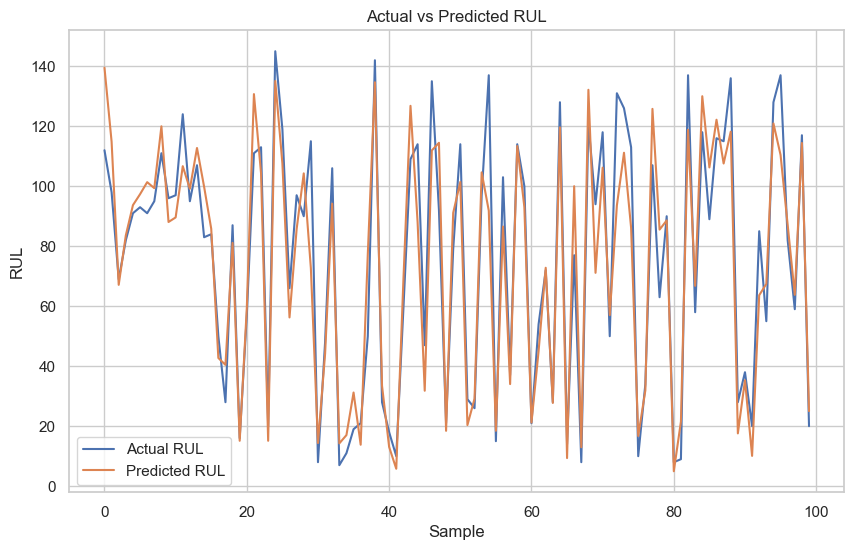

In [29]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(y_test_reshaped, label='Actual RUL')
plt.plot(y_pred_reshaped, label='Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.xlabel('Sample')
plt.ylabel('RUL')
plt.legend()
plt.show()


#### Evaluate the Model Performance

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_reshaped, y_pred_reshaped)
rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_pred_reshaped))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 10.8699160861969
Root Mean Squared Error (RMSE): 14.021366057006661


In [31]:
# Predicting the training set results
y_train_pred = best_combined_model.predict(X_train)

# Calculate MAE and RMSE on the training data
mae_train = np.mean(np.abs(y_train_pred - y_train))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train)**2))

print(f'Training Mean Absolute Error (MAE): {mae_train}')
print(f'Training Root Mean Squared Error (RMSE): {rmse_train}')


157/157 [==============================] - 5s 29ms/step
Training Mean Absolute Error (MAE): 7.689759949207306
Training Root Mean Squared Error (RMSE): 10.673255748848332


#### Regularization

In [32]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

def create_regularized_model(input_shape, l1_units=100, l2_units=50, l3_units=10, dropout_rate=0.3, l2_reg=0.01):
    model = Sequential()
    model.add(LSTM(units=l1_units, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=l2_units, return_sequences=True, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=l3_units, return_sequences=False, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
regularized_model = create_regularized_model(input_shape)

# Define callbacks
model_path = 'best_regularized_model.h5'
mc = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history = regularized_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  
    batch_size=32,
    callbacks=[mc, es]
)

# Save the model and training history
regularized_model.save('best_regularized_model.h5')

with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)




Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 6835.2129
Epoch 1: val_loss improved from inf to 6562.95801, saving model to best_regularized_model.h5
157/157 [==============================] - 32s 182ms/step - loss: 6835.2129 - val_loss: 6562.9580
Epoch 2/10


C:\Users\adler\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - ETA: 0s - loss: 6461.1470
Epoch 2: val_loss improved from 6562.95801 to 6309.05518, saving model to best_regularized_model.h5
157/157 [==============================] - 29s 183ms/step - loss: 6461.1470 - val_loss: 6309.0552
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 6218.1460
Epoch 3: val_loss improved from 6309.05518 to 6077.58203, saving model to best_regularized_model.h5
157/157 [==============================] - 28s 180ms/step - loss: 6218.1460 - val_loss: 6077.5820
Epoch 4/10
157/157 [==============================] - ETA: 0s - loss: 5985.3867
Epoch 4: val_loss improved from 6077.58203 to 5856.96729, saving model to best_regularized_model.h5
157/157 [==============================] - 28s 180ms/step - loss: 5985.3867 - val_loss: 5856.9673
Epoch 5/10
157/157 [==============================] - ETA: 0s - loss: 5760.8516
Epoch 5: val_loss improved from 5856.96729 to 5646.40625, saving model to best_regularized_model.

#### Hyperparameter Tuning

In [34]:
# Hyperparameter grid
hyperparameter_grid = {
    'units1': [32, 64],
    'units2': [32, 64],
    'dropout_rate': [0.2, 0.5],
    'batch_size': [32, 64],
    'epochs': [10, 20] 
}


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Flatten
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from itertools import product

# Function to create the LSTM model
def create_model(units1, units2, dropout_rate, input_shape):
    model = Sequential()
    model.add(LSTM(units=units1, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Variables to track the best model
best_mae = float('inf')
best_hyperparameters = None
best_model = None

# Iterate over all combinations of hyperparameters
for units1, units2, dropout_rate, batch_size, epochs in product(
        hyperparameter_grid['units1'],
        hyperparameter_grid['units2'],
        hyperparameter_grid['dropout_rate'],
        hyperparameter_grid['batch_size'],
        hyperparameter_grid['epochs']):

    print(f'Training with units1={units1}, units2={units2}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}')

    # Create and train the model
    model = create_model(units1, units2, dropout_rate, (X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'MAE: {mae}, RMSE: {rmse}')

Training with units1=32, units2=32, dropout_rate=0.2, batch_size=32, epochs=10
4/4 [==============================] - 1s 22ms/step
MAE: 12.030203409194947, RMSE: 16.295202740973643
Training with units1=32, units2=32, dropout_rate=0.2, batch_size=32, epochs=20
4/4 [==============================] - 1s 22ms/step
MAE: 12.456711149215698, RMSE: 16.350440809052323
Training with units1=32, units2=32, dropout_rate=0.2, batch_size=64, epochs=10
4/4 [==============================] - 1s 23ms/step
MAE: 12.571258249282836, RMSE: 17.29633168761031
Training with units1=32, units2=32, dropout_rate=0.2, batch_size=64, epochs=20
4/4 [==============================] - 1s 23ms/step
MAE: 12.970405158996583, RMSE: 15.60232856245773
Training with units1=32, units2=32, dropout_rate=0.5, batch_size=32, epochs=10
4/4 [==============================] - 1s 23ms/step
MAE: 16.828513545989992, RMSE: 22.688815861054923
Training with units1=32, units2=32, dropout_rate=0.5, batch_size=32, epochs=20
4/4 [=============

KeyboardInterrupt: 

The regularization and hyperparameter tuning processes are computationally intensive and time-consuming. To speed up the process, we reduced the number of epochs and iterations, which may have led to suboptimal tuning.


By reducing the parameters, such as the number of epochs and batch sizes, we might not have given the model enough time and resources to fully learn from the data and find the optimal set of hyperparameters.


The problem we are addressing may require more sophisticated tuning and possibly more complex model architectures, which we did not explore fully due to the constraints.

### DEPLOYMENT 

In [38]:
# Save the model
best_combined_model.save('best_combined_model.h5')


C:\Users\adler\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
import os
print(os.path.exists('best_combined_model.h5'))


True


In [42]:
from tensorflow.keras.models import save_model

# Assuming `combined_model` is your trained model
combined_model.save('best_combined_model.h5')


In [43]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model_path = 'best_combined_model.h5'
model = load_model(model_path)

# Define input data for prediction
input_data = np.array([[1, 2, 3, 4, 5]]).reshape(1, -1, 5)  # Adjust the shape based on your model's expected input

# Make prediction
prediction = model.predict(input_data)
print("Prediction:", prediction[0][0])


ValueError: in user code:

    File "C:\Users\adler\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\adler\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\adler\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\adler\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\adler\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\adler\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 200, 13), found shape=(None, 1, 5)
